In [1]:
!pip install idx2numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
'''import libraries'''
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
import pickle
'''pickled_model = pickle.load(open('model.pkl', 'rb'))'''

"pickled_model = pickle.load(open('model.pkl', 'rb'))"

In [3]:
'''load train & test data & labels'''
x_train = idx2numpy.convert_from_file('/content/drive/MyDrive/DL/DL Assignments/A1/train-images-idx3-ubyte')
y_train = idx2numpy.convert_from_file('/content/drive/MyDrive/DL/DL Assignments/A1/train-labels-idx1-ubyte')
x_test = idx2numpy.convert_from_file('/content/drive/MyDrive/DL/DL Assignments/A1/t10k-images-idx3-ubyte')
y_test = idx2numpy.convert_from_file('/content/drive/MyDrive/DL/DL Assignments/A1/t10k-labels-idx1-ubyte')

In [4]:
'''get shape of data'''
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

AxesImage(54,36;334.8x217.44)


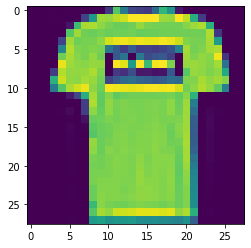

In [5]:
print(plt.imshow(x_train[1]))

In [6]:
'''reshape from 3D to 2D'''
x_train = x_train.reshape(60000, 28*28)
x_test = x_test.reshape(10000, 28*28)

In [7]:
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [8]:
'''one hot encoding y train and y test'''
import pandas as pd
y_train = np.array(pd.get_dummies(y_train))
y_test = np.array(pd.get_dummies(y_test))
y_train.shape, y_test.shape

((60000, 10), (10000, 10))

In [9]:
'''
Normalize data to bring it between 0 to 1
Divide by 255 as it represents the color range
'''
x_train = x_train/255
x_test = x_test/255

In [10]:
'''defining class'''
class NeuralNetwork:
  '''
  init funciton to initialize weights & bias
  '''
  def __init__(self, inputLayerSize, hiddenLayerSize, init_weights):
    if init_weights=='zero':
      self.w1 = np.zeros((inputLayerSize, hiddenLayerSize))
      self.w2 = np.zeros((hiddenLayerSize,10))
    
    elif init_weights=='normal':
      self.w1 = np.random.randn(inputLayerSize, hiddenLayerSize)
      self.w2 = np.random.randn(hiddenLayerSize, 10)

    self.b1 = np.random.randn(1,hiddenLayerSize)
    self.b2 = np.random.randn(1,10)


  def accuracy(self, X,Y,act_func):
    '''this function calculates the accuracy'''
    acc = 0
    for x,y in zip(X,Y):
      _,_,_,a2 = self.forward_pass(x, act_func)
      if np.argmax(a2) == np.argmax(y):
        acc+=1
    return acc/len(X)*100

  '''activation functions'''
  def ReLU(self,x):
    return np.maximum(x, 0)

  '''returns 1(slope) if number is greater than 0'''
  def ReLUDerivative(self,x):
    return x>0

  def sigmoid(self,x):
    return 1/(1+np.exp(-x))

  def sigmoidDerivative(self,x):
    return self.sigmoid(x) * (1 - self.sigmoid(x))

  def softmax(self,x):
    exps = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exps/np.sum(exps, axis=1, keepdims=True)

  def forward_pass(self, x, act_func):
    '''
    Multiply input data with weights of first layer and add bias.
    This was goes to the relevant activation function.
    '''
    z1 = x @ self.w1 + self.b1
    if act_func=='relu':
      a1 = self.ReLU(z1)
    elif act_func=='sigmoid':
      a1 = self.sigmoid(z1)
    '''
    The output of that activation function is again multiplied to the weight of the next layer added with bias.
    Finally, softmax actovation is used for the last layer.
    '''
    z2 = a1 @ self.w2 + self.b2
    a2 = self.softmax(z2)
    return z1, a1, z2, a2
  
  def backward_pass(self, Z1, A1, Z2, A2, X, Y, act_func, alpha):
    '''
    This function updates & returns the updated weights & biases (parameters) after calculating the loss.
    Loss is difference in expected & predicted value, computed in the first line.
    '''
    delA2 = crossEntropyLoss(A2,Y)
    delZ1 = np.dot(delA2,self.w2.T)
    if act_func=='relu':
      delA1 = delZ1 * self.ReLUDerivative(Z1)
    elif act_func=='sigmoid':
      delA1 = delZ1 * self.sigmoidDerivative(Z1)
    
    self.w2 = self.w2 - alpha * np.dot(A1.T, delA2)
    self.w1 = self.w1 - alpha * np.dot(X.T, delA1)
    self.b2 = self.b2 - alpha * np.sum(delA2, axis=0)
    self.b1 = self.b1 - alpha * np.sum(delA1, axis=0)

    # return self.w1, self.b1, self.w2, self.b2

In [11]:
def error(pred, true):
  '''Funtion to compute the loss'''
  logp = - np.log(pred[np.arange(true.shape[0]), true.argmax(axis=1)])
  loss = np.sum(logp)/true.shape[0]
  return loss

def crossEntropyLoss(pred, true):
  return (pred - true)/true.shape[0]

In [12]:
# Initialize hyper-parameters
hiddenLayerSize = 64
X = x_train
Y = y_train
inputLayerSize = X.shape[1]
epoch = 100
alpha = 0.1

### 1. Sigmoid & Normal Weights

In [ ]:
'''Sigmoid & Gaussian Distributed Weights'''

# create class object with taken hyperparameters
m1 = NeuralNetwork(inputLayerSize, hiddenLayerSize, 'normal')

'''list to store losses & accuracies'''
train_loss = []
test_loss = []
train_accuracies = []
test_accuracies = []

for i in range(epoch):
  z1, a1, z2, a2 = m1.forward_pass(X, 'sigmoid')
  train_loss.append(error(a2,Y))
  test_loss.append(error(a2,y_test))
  m1.backward_pass(z1, a1, z2, a2, X, Y, 'sigmoid', alpha)
  train_accuracies.append(m1.accuracy(X, Y, 'sigmoid'))
  test_accuracies.append(m1.accuracy(x_test, y_test, 'sigmoid'))

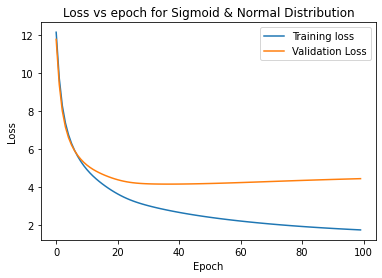

In [ ]:
'''Plot training & validation loss vs epoch'''
e = np.arange(0,epoch)
plt.plot(e, train_loss, label='Training loss')
plt.plot(e, test_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs epoch for Sigmoid & Normal Distribution')
plt.show()

* Training loss is minimized after 90 epoch, meaning the model has learned well enough.
* Test loss, on the other hand, reduces drastically in the first 10 epochs, implying that the model is able to generalize well.

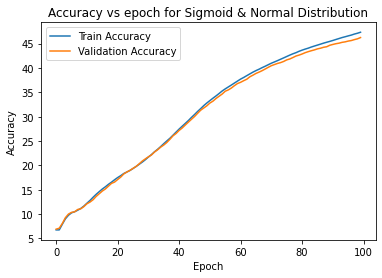

In [ ]:
'''Plot training & validation accuracy vs epoch'''
plt.plot(e, train_accuracies, label = 'Train Accuracy')
plt.plot(e, test_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs epoch for Sigmoid & Normal Distribution')
plt.show()

Accuracy increases with epochs, meaning that at every epoch, our model is learning new features and using it to make predictions.

In [ ]:
print("Accuracy:", test_accuracies[-1])

Accuracy: 46.239999999999995


In [ ]:
'''Dump the model using pickle file'''
pickle.dump(m1, open('sigmoid_normal.pkl', 'wb'))

In [ ]:
# test1 = NeuralNetwork(inputLayerSize, hiddenLayerSize, 'normal')
# pickled_model = pickle.load(open('sigmoid_normal.pkl', 'rb'))
# test1.w1 = pickled_model.w1
# test1.b1 = pickled_model.b1
# test1.w2 = pickled_model.w2
# test1.b2 = pickled_model.b2

# test1.accuracy(x_test, y_test,'sigmoid')

### 2. Sigmoid & Zero Weights

In [ ]:
'''Sigmoid & 0 Weights'''

# create class object with taken hyperparameters
m2 = NeuralNetwork(inputLayerSize, hiddenLayerSize, 'zero')
'''list to store losses & accuracies'''
train_loss = []
test_loss = []
train_accuracies = []
test_accuracies = []

for i in range(epoch):
  z1, a1, z2, a2 = m2.forward_pass(m2.w1, m2.b1, m2.w2, m2.b2, X, 'sigmoid')
  train_loss.append(error(a2,Y))
  test_loss.append(error(a2,y_test))
  w1, b1, w2, b2 = m2.backward_pass(z1, a1, z2, a2, m2.w1, m2.w2, X, Y, 'sigmoid', alpha)
  train_accuracies.append(m2.accuracy(X, Y, 'sigmoid'))
  test_accuracies.append(m2.accuracy(x_test, y_test, 'sigmoid'))

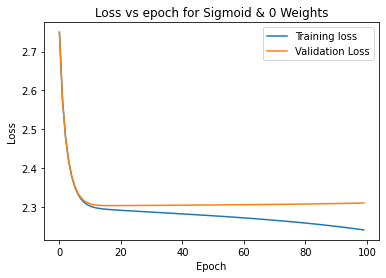

In [ ]:
'''Plot training & validation loss vs epoch'''
e = np.arange(0,epoch)
plt.plot(e, train_loss, label='Training loss')
plt.plot(e, test_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs epoch for Sigmoid & 0 Weights')
plt.show()

* Training loss decreases linearly after 20th epoch.
* No change in test loss after 10 epochs beacuse all the weights are 0.

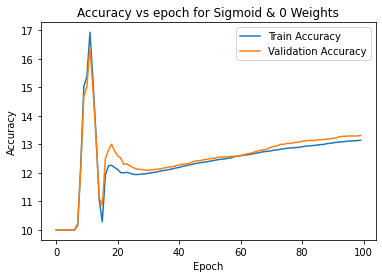

In [ ]:
'''Plot training & validation accuracy vs epoch'''
e = np.arange(0,epoch)
plt.plot(e, train_accuracies, label = 'Train Accuracy')
plt.plot(e, test_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs epoch for Sigmoid & 0 Weights')
plt.show()

* Here, the model arbitrarily outputs some predictions resulting in sudden surge & fall.
* So it can't make accurate predictions.

In [ ]:
print("Accuracy:", test_accuracies[-1])

Accuracy: 13.309999999999999


In [ ]:
'''Dump the model using pickle file'''
pickle.dump(m2, open('sigmoid_zero.pkl', 'wb'))

In [ ]:
# test2 = NeuralNetwork(inputLayerSize, hiddenLayerSize, 'zero')
# pickled_model = pickle.load(open('sigmoid_zero.pkl', 'rb'))
# test2.w1 = pickled_model.w1
# test2.b1 = pickled_model.b1
# test2.w2 = pickled_model.w2
# test2.b2 = pickled_model.b2

# test2.accuracy(x_test, y_test,'sigmoid')

### 3. ReLU & Normal Weights

In [ ]:
'''relu & Gaussian Distributed Weights'''

# create class object with taken hyperparameters
m3 = NeuralNetwork(inputLayerSize, hiddenLayerSize, 'normal')
'''lists to store losses & accuracies'''
train_loss = []
test_loss = []
train_accuracies = []
test_accuracies = []

for i in range(epoch):
  z1, a1, z2, a2 = m3.forward_pass(m3.w1, m3.b1, m3.w2, m3.b2, X, 'relu')
  train_loss.append(error(a2,Y))
  test_loss.append(error(a2,y_test))
  w1, b1, w2, b2 = m3.backward_pass(z1, a1, z2, a2, m3.w1, m3.w2, X, Y, 'relu', alpha)
  train_accuracies.append(m3.accuracy(X, Y, 'relu'))
  test_accuracies.append(m3.accuracy(x_test, y_test, 'relu'))

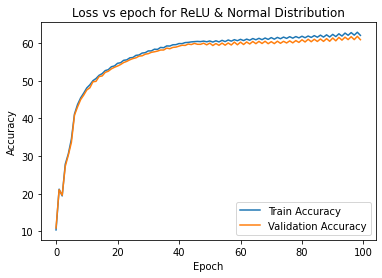

In [ ]:
'''Plot training & validation accuracy vs epoch'''
e = np.arange(0,epoch)
plt.plot(e, train_accuracies, label = 'Train Accuracy')
plt.plot(e, test_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs epoch for ReLU & Normal Distribution')
plt.show()

* Accuracy increases drastically for the first 10 epochs, meaning that our model is able to extract features and make predictions based on it.

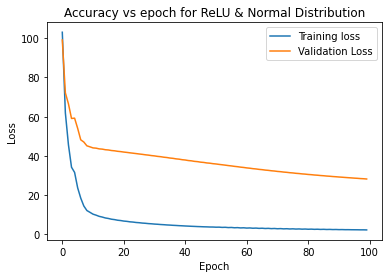

In [ ]:
'''Plot training & validation loss vs epoch'''
e = np.arange(0,epoch)
plt.plot(e, train_loss, label='Training loss')
plt.plot(e, test_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs epoch for ReLU & Normal Distribution')
plt.show()

* Training loss steadily decreases after 20 epochs and reaches minimum.
* Test loss reduces in linear fashion. So we extrapolate the loss to a higher number of epochs, we might be able to achieve higher accuracy.

In [ ]:
print("Accuracy:", test_accuracies[-1])

Accuracy: 60.919999999999995


In [ ]:
'''Dump the model using pickle file'''
pickle.dump(m3, open('relu_normal.pkl', 'wb'))

In [ ]:
# test3 = NeuralNetwork(inputLayerSize, hiddenLayerSize, 'normal')
# pickled_model = pickle.load(open('relu_normal.pkl', 'rb'))
# test3.w1 = pickled_model.w1
# test3.b1 = pickled_model.b1
# test3.w2 = pickled_model.w2
# test3.b2 = pickled_model.b2

# test3.accuracy(x_test, y_test,'relu')

### 4. ReLU & 0 Weights

In [ ]:
''' relu & 0 Weights'''

# create class object with taken hyperparameters
m4 = NeuralNetwork(inputLayerSize, hiddenLayerSize, 'zero')
'''lists to store losses & accuracies'''
train_loss = []
test_loss = []
train_accuracies = []
test_accuracies = []

for i in range(epoch):
  z1, a1, z2, a2 = m4.forward_pass(m4.w1, m4.b1, m4.w2, m4.b2, X, 'relu')
  train_loss.append(error(a2,Y))
  test_loss.append(error(a2,y_test))
  w1, b1, w2, b2 = m4.backward_pass(z1, a1, z2, a2, m4.w1, m4.w2, X, Y, 'relu', alpha)
  train_accuracies.append(m4.accuracy(X, Y, 'relu'))
  test_accuracies.append(m4.accuracy(x_test, y_test, 'relu'))

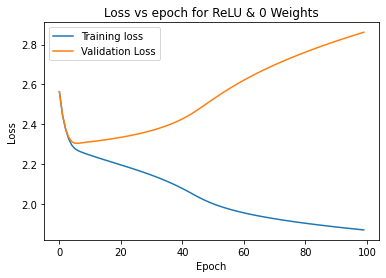

In [ ]:
'''Plot training & validation loss vs epoch'''
e = np.arange(0,epoch)
plt.plot(e, train_loss, label='Training loss')
plt.plot(e, test_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs epoch for ReLU & 0 Weights')
plt.show()

* Training loss decreases but test loss increase because there is no change in parameters.

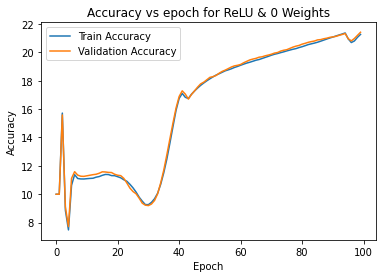

In [ ]:
'''Plot training & validation accuracy vs epoch'''
e = np.arange(0,epoch)
plt.plot(e, train_accuracies, label = 'Train Accuracy')
plt.plot(e, test_accuracies, label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs epoch for ReLU & 0 Weights')
plt.show()

* Here, the model arbitrarily outputs some predictions resulting in sudden surge & fall.
* So it can't make accurate predictions.

In [ ]:
print("Accuracy:", test_accuracies[-1])

Accuracy: 21.42


In [ ]:
'''Dump the model using pickle file'''
pickle.dump(m4, open('relu_zero.pkl', 'wb'))

In [ ]:
# test4 = NeuralNetwork(inputLayerSize, hiddenLayerSize, 'zero')
# pickled_model = pickle.load(open('relu_zero.pkl', 'rb'))
# test4.w1 = pickled_model.w1
# test4.b1 = pickled_model.b1
# test4.w2 = pickled_model.w2
# test4.b2 = pickled_model.b2

# test4.accuracy(x_test, y_test,'relu')